# Problema de clasificación usando Random Forest

## Autores: Mauricio Beltrán, Pablo Sánchez, Alfonoso Carabantes y Juan Antonio Grande

Se plantea determinar si una persona gana más de 50,000 dólares al año a partir de las siguientes variables:

- age: Variable continua que representa la edad del individuo.
- workclass: Variable categórica que representa el tipo de clase laboral a la que pertenece el individuo. Los posibles valores incluyen Privado, Trabajador autónomo (no incorporado), Trabajador autónomo (incorporado), Gobierno federal, Gobierno local, Gobierno estatal, Sin paga, Nunca trabajó.
- fnlwgt: Variable continua que representa el peso final de la población, utilizado en el muestreo.
- education: Variable categórica que representa el nivel más alto de educación alcanzado por el individuo. Los posibles valores incluyen varios niveles de educación desde Preescolar hasta Doctorado.
- education-num: Variable continua que representa la codificación numérica de la educación (una representación alternativa de la característica 'education').
- marital-status: Variable categórica que representa el estado civil del individuo. Los posibles valores incluyen Casado (cónyuge civil), Divorciado, Soltero, Separado, Viudo, Casado (cónyuge ausente), Casado con Fuerzas Armadas.
- occupation: Variable categórica que representa la ocupación del individuo. Los posibles valores incluyen diversas categorías laborales como Soporte técnico, Ventas, Ejecutivo/Gerencial, Agricultura/Pesca, etc.
- relationship: Variable categórica que representa la relación del individuo con el hogar. Los posibles valores incluyen Esposa, Hijo propio, Esposo, No pertenece a la familia, Pariente, Soltero.
- race: Variable categórica que representa la raza del individuo. Los posibles valores incluyen Blanco, Asiático-isleño del Pacífico, Indígena americano-Eskimal, Negro, Otro.
- sex: Variable categórica que representa el género del individuo. Los posibles valores son Mujer y Hombre.
- capital-gain: Variable continua que representa las ganancias de capital del individuo.
- capital-loss: Variable continua que representa las pérdidas de capital del individuo.
- hours-per-week: Variable continua que representa el número de horas trabajadas por semana por el individuo.
- native-country: Variable categórica que representa el país de origen del individuo. Los posibles valores incluyen varios países como Estados Unidos, India, Japón, México, etc.

Se puede descargar los datos en: https://archive.ics.uci.edu/dataset/2/adult

## Importar datos y librerías de trabajo

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score
from numpy.random import seed
seed(123)

Se leen los datos. Y un pequeño resumen de las variables numéricas:

In [2]:
datos=pd.read_csv('../data/adult_data.csv').drop(columns=["x"])

datos = datos.drop(columns=["fnlwgt", "educational-num"])

datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   education       48842 non-null  object
 3   marital-status  48842 non-null  object
 4   occupation      48842 non-null  object
 5   relationship    48842 non-null  object
 6   race            48842 non-null  object
 7   gender          48842 non-null  object
 8   capital-gain    48842 non-null  int64 
 9   capital-loss    48842 non-null  int64 
 10  hours-per-week  48842 non-null  int64 
 11  native-country  48842 non-null  object
 12  income          48842 non-null  object
dtypes: int64(4), object(9)
memory usage: 4.8+ MB


In [3]:
# Breve explicación del dataset
print('Tamaño:', datos.shape)  # 284.807 registros y 31 variables

datos.describe()  #summary de las variables (30 variables explicativas y target: Class)

Tamaño: (48842, 13)


,age,capital-gain,capital-loss,hours-per-week
count,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1079.067626,87.502314,40.422382
std,13.710510,7452.019058,403.004552,12.391444
min,17.000000,0.000000,0.000000,1.000000
25%,28.000000,0.000000,0.000000,40.000000
50%,37.000000,0.000000,0.000000,40.000000
75%,48.000000,0.000000,0.000000,45.000000
max,90.000000,99999.000000,4356.000000,99.000000


## Agrupación de niveles de las variables categóricas

`workclass`

In [4]:
cond = [datos["workclass"].isin(["Self-emp-not-inc", "Self-emp-inc"]),
        datos["workclass"].isin(["State-gov", "Local-gov", "Federal-gov"]),
        datos["workclass"].isin(["?", "Without-pay", "Never-worked"])]
values = ["Self", "State", "Other"]

datos["workclass"] = np.select(cond, values, default=datos["workclass"])
datos["workclass"] = datos["workclass"].astype("category")

`education`

In [5]:
cond = [datos["education"].isin(["Assoc-acdm", "Assoc-voc"]),
        datos["education"].isin(["Preschool", "HS-grad"]),
        datos["education"].isin(["Bachelors", "Masters", "Doctorate", "Some-college"]),
        datos["education"] == "Prof-school"]
values = ["Associate", "School", "BCMD", "Prof-school"]

datos["education"] = np.select(cond, values, default="Xth")
datos["education"] = datos["education"].astype("category")

`marital-status`

In [6]:
cond = [datos["marital-status"].isin(["Separated", "Divorced"]),
        datos["marital-status"].isin(["Married-civ-spouse", "Married-spouse-absent", "Married-AF-spouse"]),
        datos["marital-status"] == "Widowed"]
values = ["Divorced/Separated", "Married", "Widowed"]

datos["marital-status"] = np.select(cond, values, default="Never-married")
datos["marital-status"] = datos["marital-status"].astype("category")

`occupation`

In [7]:
values = ["Protective-serv", "Craft-repair", "Exec-managerial", "Adm-clerical", "Sales", "Machine-op-inspct"]
datos["occupation"] = np.where(datos["occupation"].isin(values), datos["occupation"], "Other")
datos["occupation"] = datos["occupation"].astype("category")

## Análisis descriptivo y preprocesado de datos

`Distribución del Target`

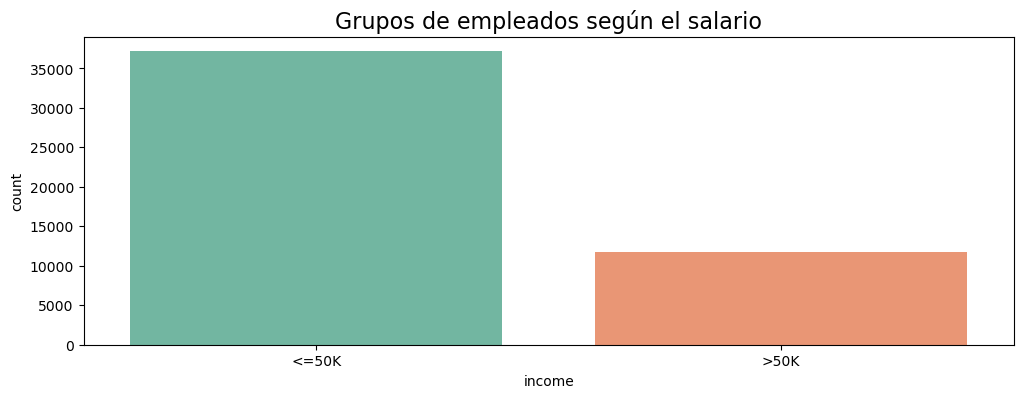

In [10]:
plt.figure(figsize=(12, 4)) # tamaño del gráfico
sns.countplot(x='income', data=datos, palette='Set2')
plt.title('Grupos de empleados según el salario', fontsize=16)
plt.show()

datos["income"].value_counts(normalize=True)

datos["income"] = np.where(datos["income"] == ">50K", 1, 0)

`Correlación variables numéricas`

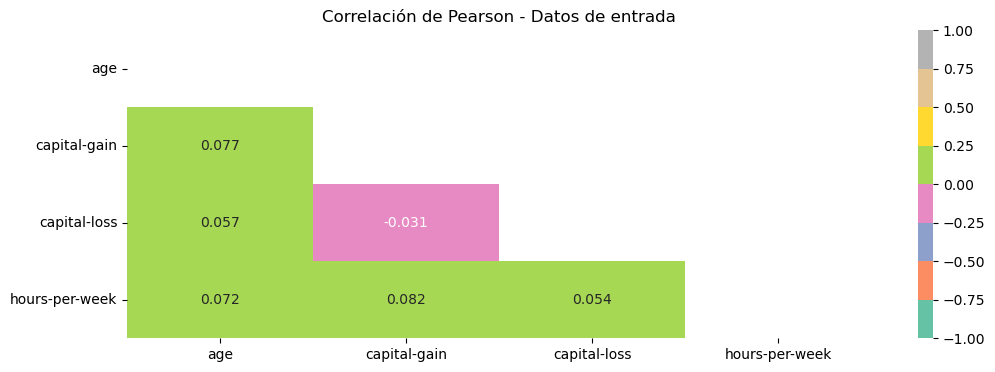

In [11]:
# nombre de las columnas de interés
columnas_corr = list(datos.select_dtypes(exclude=['category', 'object']).columns)
corr_list = columnas_corr.copy()
corr_list.remove("income")

# Análisis de correlación de las variables explicativas
matriz_cor=datos[corr_list].corr('pearson')  #correlación de pearson

# como cor(x,x)=1 y cor(x,y)=cor(y,x) se puede disponer solo de la diagonal inferior.
# La siguiente función elimina la parte superior de la matriz de correlaciones
mask = np.zeros(matriz_cor.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True

plt.figure(figsize=(12, 4)) # tamaño del gráfico

sns.heatmap(matriz_cor, annot = True, vmin = -1, vmax = 1, cmap = 'Set2', mask=mask)
# cmap para elegir la gama de colores y vmin y vmax identificar todo el espectro de valores de la correlación de pearson [-1,1]
plt.title('Correlación de Pearson - Datos de entrada', fontsize=12)
plt.show()

Vemos que no hay correlación lineal entre las variables explicativas

## Definición de la muestra: entrenamiento y validación

In [12]:
# Partición de la muestra
TEST_SIZE = 0.25 #muestra para el test
RANDOM_SEED = 123 
X_train, X_test, y_train, y_test = train_test_split(datos.drop(columns=["income"]),
                                                    datos["income"],
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_SEED,
                                                    stratify=datos["income"]) # división estratificada

print(f"Tamaño train: {X_train.shape}")
print(f"Tamaño validación: {X_test.shape}")

Tamaño train: (36631, 12)
Tamaño validación: (12211, 12)


Se convierten a variables dummy las no numéricas

In [13]:
category_columns = list(datos.select_dtypes(include=['category', 'object']).columns)

X_train_dummy = pd.get_dummies(X_train[category_columns], drop_first=True, dtype=float)
X_test_dummy = pd.get_dummies(X_test[category_columns], drop_first=True, dtype=float)

Obtenemos las variables numéricas y concatenamos:

In [14]:
X_train_num = X_train[corr_list]
X_test_num = X_test[corr_list]

X_train = pd.concat([X_train_num, X_train_dummy], axis=1) # se añaden a nivel registro
X_test = pd.concat([X_test_num, X_test_dummy], axis=1)

Al trabajar con variables categóricas puede ser que algún nivel de los datos de entrenamiento no esté en nuestros datos de validación.

In [15]:
True if len(X_train.columns) == len(X_test.columns) else False

False

Puede verse que existe tal discrepancia. Se analizan las variables que no existen para rellenarlas a cero.

In [16]:
add_col_test = [col for col in X_train.columns if col not in X_test.columns]
add_col_test

['native-country_Holand-Netherlands']

In [17]:
for col in add_col_test:
    X_test[col] = 0 # se incluye con valor a cero

X_test = X_test[X_train.columns] # la muestra de test con el mismo orden que la muestra de entrenamiento

In [18]:
True if len(X_train.columns) == len(X_test.columns) else False

True

In [19]:
datos["hours-per-week"].max()

99

Una vez tenemos los datos de entrada adecuadamente formulados, se normalizan los datos:

In [20]:
# Normalización muestra entrenamiento y test

# conversión a vector numpy la serie de pandas
y_train=np.array(y_train)
y_test=np.array(y_test)

# Los datos son normalizados (min=0, máx=1) para un buen entendimiento de la red neuronal
norm = MinMaxScaler()
X_train = norm.fit_transform(X_train)
X_test = norm.transform(X_test)

In [21]:
# detalle del tamaño de los datos de entrada
print('Tamaño datos (train):', X_train.shape)
print('Tamaño datos (test):', X_test.shape)

Tamaño datos (train): (36631, 71)
Tamaño datos (test): (12211, 71)


El entrenamiento es realizado usando la técnica de Cross-Validation:
- n_splits: 10
- n_repeats: 2

In [22]:
N_SPLITS = 10
N_REPEATS = 2

# cross_validation
cv = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RANDOM_SEED)

## Modelización usando un Random Forest

Se defininen los parámetros e hiperparámetros del modelo:
- Criterion: gini
- min_samples_split: 5
- n_stimators: 6, 8, 10 y 12
- max_depth: 2 y 4

In [23]:
CRITERION = "gini"
MIN_SAMPLES_SPLIT = 5
N_JOBS = -1 
HYPERPARAMETER_DICT = {'n_estimators':[6, 8, 10, 12], 'max_depth': [2, 4]}

In [24]:
# métrica de evaluación: accuracy
METRIC = "accuracy"


rf = RandomForestClassifier(criterion=CRITERION,
                            min_samples_split=MIN_SAMPLES_SPLIT,
                            random_state=RANDOM_SEED) #modelo base

# definición de los hiperparámetros como grid
grid = [HYPERPARAMETER_DICT]

#definición del modelo con hiperparámetros
gs_rf = GridSearchCV(estimator=rf,
                     param_grid=grid,
                     scoring=METRIC,
                     cv=cv,
                     n_jobs=N_JOBS)

#entrenamiento del modelo con hiperparámetros
gs_rf = gs_rf.fit(X_train, y_train)

Una vez hecho el entrenamiento por cross validation se puede conocer la combinación de hiperparámetros que proporcionan el mejor modelo

In [25]:
gs_rf.best_params_

{'max_depth': 4, 'n_estimators': 12}

También se pueden obtener los resultados del entrenamiento de cada uno de los modelos - media todos los split o de cada split.

In [26]:
for params, mean_metric in zip(gs_rf.cv_results_["params"], gs_rf.cv_results_["mean_test_score"]):
    print(f"Hyperparams: {params}: {mean_metric}")
    
# El objeto devuelto `gf_rf.cv_results_` es un diccionario que puede convertirse a dataframe -> pd.DataFrame(gs_rf.cv_results_)

Hyperparams: {'max_depth': 2, 'n_estimators': 6}: 0.760735445151384
Hyperparams: {'max_depth': 2, 'n_estimators': 8}: 0.7607490951650341
Hyperparams: {'max_depth': 2, 'n_estimators': 10}: 0.7607900414805437
Hyperparams: {'max_depth': 2, 'n_estimators': 12}: 0.7659496311515962
Hyperparams: {'max_depth': 4, 'n_estimators': 6}: 0.8010837790450236
Hyperparams: {'max_depth': 4, 'n_estimators': 8}: 0.8012066403441949
Hyperparams: {'max_depth': 4, 'n_estimators': 10}: 0.8092190269864943
Hyperparams: {'max_depth': 4, 'n_estimators': 12}: 0.8159073772065039


Se obtiene el mejor modelo

In [27]:
model = gs_rf.best_estimator_

Se analiza la bondad de ajuste con la muestra de entrenamiento (completa) y los datos de test. 

In [28]:
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, min_samples_split=5, n_estimators=12,
                       random_state=123)

Las probabilidades que proporciona este tipo de algoritmo no están calibradas por lo que se realiza una calibración a posteriori

In [29]:
calibrated_model = CalibratedClassifierCV(model, cv=cv)
calibrated_model.fit(X_train, y_train)

CalibratedClassifierCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=10, random_state=123),
                       estimator=RandomForestClassifier(max_depth=4,
                                                        min_samples_split=5,
                                                        n_estimators=12,
                                                        random_state=123))

Como está desbalanceado se considera un `threshold=0.3`. Se usa como métrica de bondad de ajuste el f1-score

In [30]:
THRESHOLD = 0.3

# F1-score (train and test)
print("f1-score")
print("------------------------------")
print(f"Train: {f1_score(y_train, np.where(calibrated_model.predict_proba(X_train)[: , 1] >= THRESHOLD, 1, 0))}")
print(f"Test: {f1_score(y_test, np.where(calibrated_model.predict_proba(X_test)[: , 1] >= THRESHOLD, 1, 0))}")

f1-score
------------------------------
Train: 0.6637197905155432
Test: 0.6636977445769285


## Guardar los modelos y el proceso

In [31]:
import joblib

joblib.dump(norm, '../model/normalization.joblib')
joblib.dump(model, '../model/rf_model.joblib')
joblib.dump(calibrated_model, '../model/rf_calib_model.joblib')

['../model/rf_calib_model.joblib']